In [0]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
# ms-python.python added
import os
try:
	os.chdir(os.path.join(os.getcwd(), '..\\..'))
	print(os.getcwd())
except:
	pass


 # Weighted Least-Squared Fitting of Gaussian Functions

 From [A Simple Algorithm for Fitting a Gaussian Function](https://ieeexplore.ieee.org/document/5999593).

 As in Caruana's algorithm, apply logarithm to the Gaussian function:
 - $\begin{align} y &= f(x; a, b, c) \\ &= A \exp\left(-\frac{(x - \mu)^2}{2 \sigma^2}\right) \\ \ln(y) &= a + b x + c x^2 \end{align}$
 - $\begin{align} a &= \ln(A) - \frac{\mu^2}{2 \sigma^2} \\ b &= \frac{\mu}{\sigma^2} \\ c &= -\frac{1}{2 \sigma^2} \end{align}$
 - $\begin{align} \mu &= -\frac{b}{2 c} \\ \sigma &= \sqrt{-\frac{1}{c}} \\ A &= \exp \left(a - \frac{b^2}{4 c} \right) \end{align}$


 Assume $\hat{y} = y + \epsilon$.

 Define the weighted $L^2$ loss function:
 $\mathcal{L}(y_n, x_n) = \hat{y}_n^2 \left[ \ln(\hat{y}_n) - (a + b x_n + c x_n^2) \right]^2$

 Minimize the cost function:
 - $\mathcal{C} = \frac{1}{N} \sum\limits_{n=1}^N \mathcal{L}(y_n, x_n)$
 - $\nabla_\theta \: \mathcal{C} = 0$
 - $\theta = a, b, c$


 Thus:
 - $\mathbf{M} \mathbf{v} = \mathbf{w}$
 - $M_{ij} = \sum\limits_{n=1}^N x_n^{i + j} \hat{y}_n^2$
 - $\mathbf{v} = \begin{bmatrix} a \\ b \\ c \end{bmatrix}$
 - $w_i = \sum\limits_{n=1}^N x_n^{i-1} \hat{y}_n^2 \ln(\hat{y}_n)$
 - solve for $v$ by QR decomposition and back substitution.


 Iterative approach:
 - $\mathcal{L}^\prime = \left( y_n^{(k-1)} \right)^2 \left[ \ln(\hat{y}_n) - (a + b x_n + c x_n^2) \right]^2$
 - $\mathbf{M}^{(k-1)} \mathbf{v}^{(k)} = \mathbf{w}^{(k-1)}$
 - $M_{ij}^{(k-1)} = \sum\limits_{n=1}^N x_n^{i + j} \left( y_n^{(k-1)} \right)^2$
 - $\mathbf{v}^{(k)} = \begin{bmatrix} a^{(k)} \\ b^{(k)} \\ c^{(k)} \end{bmatrix}$
 - $w_i^{(k-1)} = \sum\limits_{n=1}^N x_n^{i-1} \left( y_n^{(k-1)} \right)^2 \ln(\hat{y}_n)$
 - $y_n^{k} = \begin{cases} \hat{y}_n & k = 0 \\ f(x_n; a^{(k)}, b^{(k)}, c^{(k)}) & k > 0 \end{cases}$

In [1]:
import numpy as np
from scipy.stats import poisson
import matplotlib.pyplot as plt

# helper functions
def gauss_func(x, A, mu, sig):
    return A*np.exp((-1/(2*sig**2))*(x - mu)**2)

def gauss_func_param(x, a, b, c):
    return np.exp(a + b*x + c*x**2)

def gauss_to_param(A, mu, sig):
    a = np.log(A) - (mu**2)/(2*sig**2)
    b = mu/(sig**2)
    c = -1/(2*sig**2)
    return np.array([a, b, c])

def param_to_gauss(a, b, c):
    mu = -b/(2*c)
    sig = np.sqrt(-1/(2*c))
    A = np.exp(a - (b**2)/(4*c))
    return np.array([A, mu, sig])

def m_matrix(x, y):
    m_11 = np.sum(y*y)
    m_12 = np.sum(y*y*x)
    m_13 = np.sum(y*y*x*x)
    m_23 = np.sum(y*y*x*x*x)
    m_33 = np.sum(y*y*x*x*x*x)
    return np.array([[m_11, m_12, m_13], [m_12, m_13, m_23], [m_13, m_23, m_33]])

def w_vector(x, y_k, y_hat):
    w_1 = np.sum(y_k*y_k*np.log(y_hat))
    w_2 = np.sum(y_k*y_k*np.log(y_hat)*x)
    w_3 = np.sum(y_k*y_k*np.log(y_hat)*x*x)
    return np.array([[w_1], [w_2], [w_3]])


In [2]:
# initialize parameters
np.random.seed(0)
num_pts = 500
A = 1
mu = 0.75
sig = 0.1
snr = 0.05

# generate x, y, y_hat data
x = np.linspace(0, 1, num_pts)
y = gauss_func(x, A, mu, sig)
noise = (A*snr)*np.random.poisson(1, num_pts)
y_hat = y + noise
y_0 = 0.0


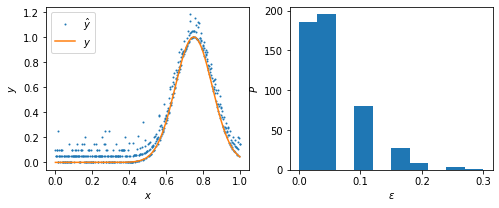

In [3]:
# plot data
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (8, 3))
ax[0].plot(x, y_hat, linestyle = 'none', marker = '.', markersize = 2, label = '$\hat{y}$')
ax[0].plot(x, y + y_0, label = '$y$')
_ = ax[0].set_xlabel('$x$')
_ = ax[0].set_ylabel('$y$')
_ = ax[0].legend()

ax[1].hist(noise)
_ = ax[1].set_xlabel('$\epsilon$')
_ = ax[1].set_ylabel('$P$')


In [4]:
# initialize loop
K = 10
loss = np.empty(K)
v_gauss = np.empty((3, K))
for k in range(K):

    if k == 0:
        y_k = y_hat
    else:
        y_k = gauss_func_param(x, a, b, c)
    
    M = m_matrix(x, y_k)
    w = w_vector(x, y_k, y_hat)
    a, b, c = np.linalg.solve(M, w)

    A, mu, sig = param_to_gauss(a, b, c)
    v_gauss[:, k] = [A, mu, sig]

    loss[k] = (1.0/num_pts)*np.sum((gauss_func(x, A, mu, sig) - y)**2)


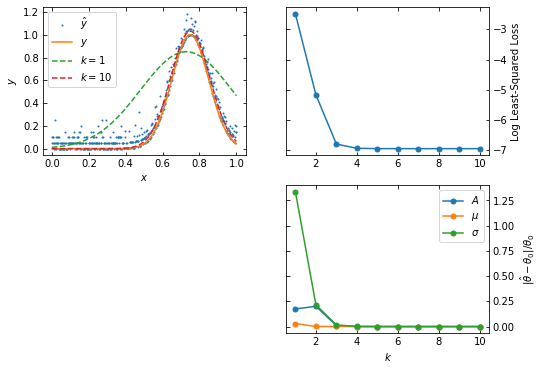

In [5]:
# plot results
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (8, 6))
ax[0, 0].plot(x, y_hat, linestyle = 'none', marker = '.', markersize = 2, label = '$\hat{y}$')
ax[0, 0].plot(x, y + y_0, label = '$y$')
ax[0, 0].plot(x, gauss_func(x, v_gauss[0, 0], v_gauss[1, 0], v_gauss[2, 0]), linestyle = '--', label = '$k = 1$')
ax[0, 0].plot(x, gauss_func(x, v_gauss[0, K-1], v_gauss[1, K-1], v_gauss[2, K-1]), linestyle = '--', label = f'$k = {K}$')
_ = ax[0, 0].set_xlabel('$x$')
_ = ax[0, 0].set_ylabel('$y$')
_ = ax[0, 0].legend()
ax[0, 0].tick_params(axis = 'both', which = 'both', direction = 'in', top = True, right = True)

ax[0, 1].plot(np.arange(K) + 1, np.log(loss), marker = '.', markersize = 10)
_ = ax[0, 1].set_ylabel('Log Least-Squared Loss')
ax[0, 1].tick_params(axis = 'x', which = 'both', direction = 'in', top = True)
ax[0, 1].tick_params(axis = 'y', which = 'both', direction = 'in', left = True, right = True, labelleft = False, labelright = True)
ax[0, 1].yaxis.set_label_position('right')

ax[1, 0].axis('off')

ax[1, 1].plot(np.arange(K) + 1, np.abs(v_gauss[0, :] - A)/A, marker = '.', markersize = 10, label = '$A$')
ax[1, 1].plot(np.arange(K) + 1, np.abs(v_gauss[1, :] - mu)/mu, marker = '.', markersize = 10, label = '$\mu$')
ax[1, 1].plot(np.arange(K) + 1, np.abs(v_gauss[2, :] - sig)/sig, marker = '.', markersize = 10, label = '$\sigma$')
_ = ax[1, 1].set_xlabel('$k$')
_ = ax[1, 1].set_ylabel('$|\hat{\\theta} - \\theta_0|/\\theta_0$')
_ = ax[1, 1].legend()
ax[1, 1].tick_params(axis = 'x', which = 'both', direction = 'in', top = True)
ax[1, 1].tick_params(axis = 'y', which = 'both', direction = 'in', left = True, right = True, labelleft = False, labelright = True)
ax[1, 1].yaxis.set_label_position('right')
